In [131]:
import pandas as pd
import numpy as np

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# метрика
from sklearn.metrics import silhouette_score
# препроцесинг
from category_encoders import BinaryEncoder
# кластеризация
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
# понижение размерности
from sklearn.decomposition import PCA

In [132]:
trans = pd.read_csv('support/clust_data.csv')
print(trans.shape)
trans.head(3)

(147374, 20)


,ration,address,start,finish,date,month,day,dow,street,area,short_address,location,latitude,longitude,weather,price,month_str,period,id,time_zone
0,750,"Екатеринбург, ул Вилонова, 22 , кв. 77, эт. 10...",7,9,2022-01-02,1,2,6,ул Вилонова 22,Екатеринбург,"Екатеринбург, ул Вилонова 22","[56.864781199999996, 60.64482563954775]",56.864781,60.644826,-5,550,Январь,0.0,s36926,2
1,1500,"Екатеринбург, ул Михеева М.Н., 2 , кв. 793, эт...",6,8,2022-01-02,1,2,6,ул Михеева М.Н. 2,Екатеринбург,"Екатеринбург, ул Михеева М.Н. 2","[56.7805477, 60.5514291]",56.780548,60.551429,-5,650,Январь,0.0,j46568,1
2,1500,"Предельная улица, 15, посёлок Совхозный, муниц...",6,8,2022-01-02,1,2,6,Предельная ул 15,Екатеринбург,"Екатеринбург, Предельная ул 15","[56.7631478, 60.5691115]",56.763148,60.569111,-5,650,Январь,0.0,j77513,1


In [133]:
df = pd.read_csv('support/clients.csv', index_col='id')
print(df.shape)
df.head(3)

(14106, 9)


,short_address,latitude,longitude,sum_trans,period,nuniq_ration,revenue,time_zone,pop_ration
id,,,,,,,,,
j10039,"Екатеринбург, Походная ул 74",56.774542,60.634243,10,3.5,1,6500,4.0,1500
j10138,"Екатеринбург, ул Ленинградская 16",56.819255,60.544925,3,3.0,1,1650,3.0,750
j10182,"Екатеринбург, ул Куйбышева 139",56.831166,60.639862,2,2.0,1,1100,3.0,S


In [134]:
# оставляем нужных нам клиентов, которые находятся в черте города, которых определили в прошлом модуле
id_clients = trans['id'].unique()
# для разбиения на кластеры наших клиентов возьмем все признаки кроме адреса и геолокации клиента
df_loyal = df.loc[id_clients][['time_zone', 'sum_trans', 'period', 'nuniq_ration', 'revenue', 'pop_ration']]

In [135]:
# закодируем признак pop_ration
coder = BinaryEncoder(cols=['pop_ration'])
df_code = coder.fit_transform(df_loyal['pop_ration'])
df_loyal = pd.concat([df_loyal, df_code], axis=1)
df_loyal.drop('pop_ration', axis=1, inplace=True)

In [136]:
# с помощью двух методов(elbow, silhouette) определим количество кластеров 

# функция возвращает значение silhouette
def get_silhouette(num, X):
    kmeans = KMeans(n_clusters=num, init='k-means++', n_init='auto', random_state=5,)
    kmeans.fit(X)

    silhouette = silhouette_score(X, kmeans.labels_)

    return silhouette

# функция возвращает значение инерции
def get_inertia(num, X):
    k_means = KMeans(n_clusters=num, init='k-means++', n_init='auto', random_state=10)
    k_means.fit(X)
    inertia = k_means.inertia_

    return inertia

# находим значения инерции и силуэтта для разного количества кластеров
inertia_list, silhouette_list  = [], []

for i in range(1, 10):
    if i == 1:
        inertia_list.append(get_inertia(i, df_loyal))
    else:
        inertia_list.append(get_inertia(i, df_loyal))
        silhouette_list.append(get_silhouette(i, df_loyal))

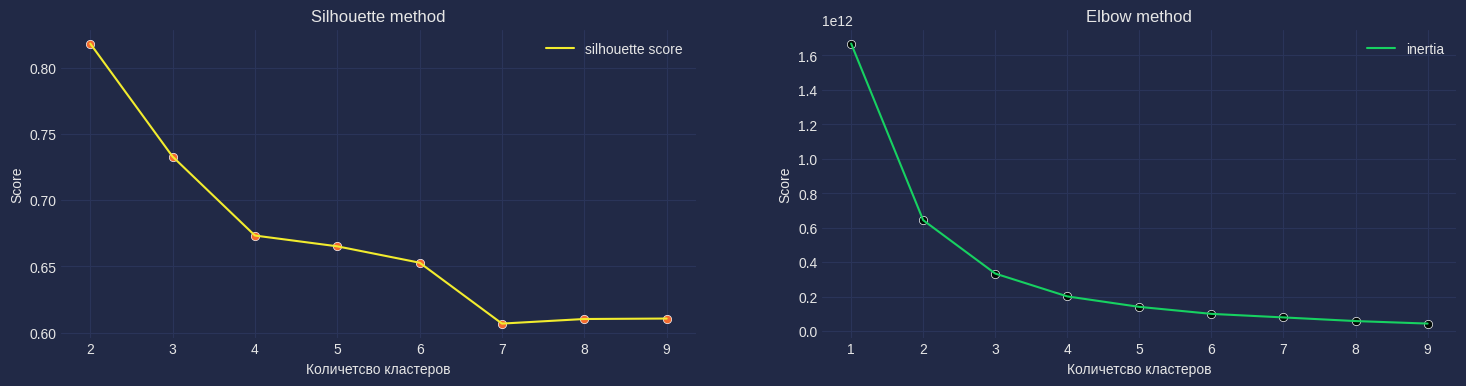

In [137]:
# визуализируем полученные результаты
fig, axes = plt.subplots(1, 2, figsize=(18, 4))

line_sil = sns.lineplot(x=range(2, 10), y=silhouette_list, label='silhouette score', color='#f2ec2e', ax=axes[0])
sns.scatterplot(x=range(2, 10), y=silhouette_list, color='#f2692e', markers=True, ax=axes[0])
line_sil.set(title='Silhouette method', xlabel='Количетсво кластеров', ylabel='Score')

line_elbow = sns.lineplot(x=range(1, 10), y=inertia_list, label='inertia', color='#17d161', ax=axes[1])
sns.scatterplot(x=range(1, 10), y=inertia_list, color='#010a05', markers=True, ax=axes[1])
line_elbow.set(title='Elbow method', xlabel='Количетсво кластеров', ylabel='Score')

plt.legend();

**Благодаря двум методам, можно опредилить, что число кластеров в нашем датасете будет равно двум-трем. Попробуем оба варианта**

**Визуализируем распространение клиентов по нашим выбранным признакм с помощью понижения размерности**

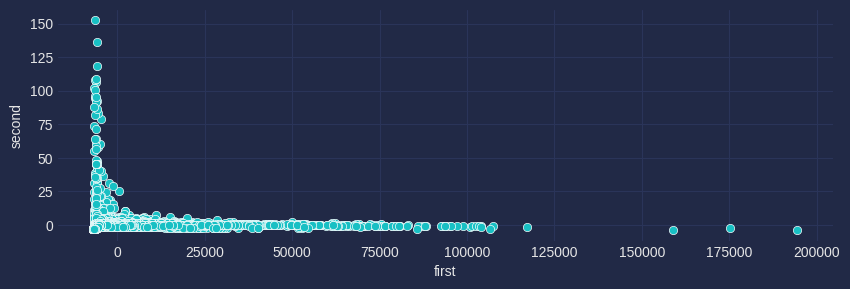

In [138]:
pca = PCA(n_components=2)

df_lo_pca = pca.fit_transform(df_loyal)
df_lo_pca = pd.DataFrame(data=df_lo_pca, columns=['first', 'second'])

fig = plt.figure(figsize=(10, 3))
sns.scatterplot(x=df_lo_pca['first'], y=df_lo_pca['second']);

**Для такой группы лучше всего производить кластерихацию при помощи Kmeans, GaussianMixture и AgglomerativeClustering**

In [139]:
ag = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_ag = ag.fit_predict(df_loyal)

gm = GaussianMixture(n_components=2)
labels_gm = gm.fit_predict(df_loyal)

km = MiniBatchKMeans(n_clusters=2, random_state=50)
labels_km = km.fit_predict(df_loyal)

/home/ya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


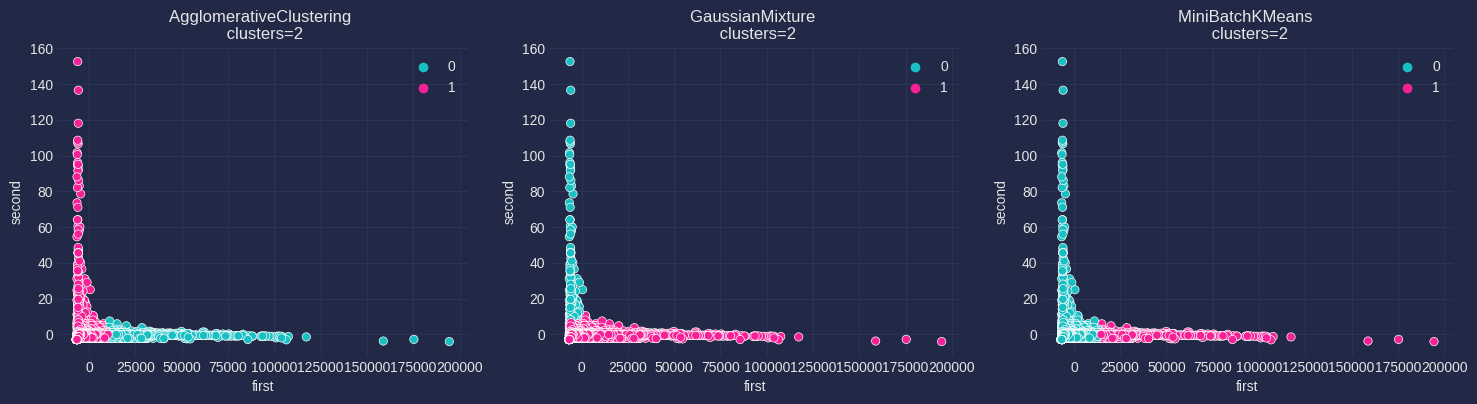

In [140]:
# визуализируем полученные результаты
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.scatterplot(x=df_lo_pca['first'], y=df_lo_pca['second'], hue=labels_ag, ax=axes[0])
axes[0].set_title('AgglomerativeClustering \n clusters=2')
sns.scatterplot(x=df_lo_pca['first'], y=df_lo_pca['second'], hue=labels_gm, ax=axes[1])
axes[1].set_title('GaussianMixture \n clusters=2')
sns.scatterplot(x=df_lo_pca['first'], y=df_lo_pca['second'], hue=labels_km, ax=axes[2])
axes[2].set_title('MiniBatchKMeans \n clusters=2');

**По полученным графикам видно, что три алгоритма по разному воспринимают край левого нижнего угла. Поэтому будет логично попробывать разбить наши данные на три кластера**

In [141]:
ag_mode = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_ag_mode = ag_mode.fit_predict(df_loyal)

gm_mode = GaussianMixture(n_components=3)
labels_gm_mode = gm_mode.fit_predict(df_loyal)

km_mode = MiniBatchKMeans(n_clusters=3, random_state=14)
labels_km_mode = km_mode.fit_predict(df_loyal)

/home/ya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


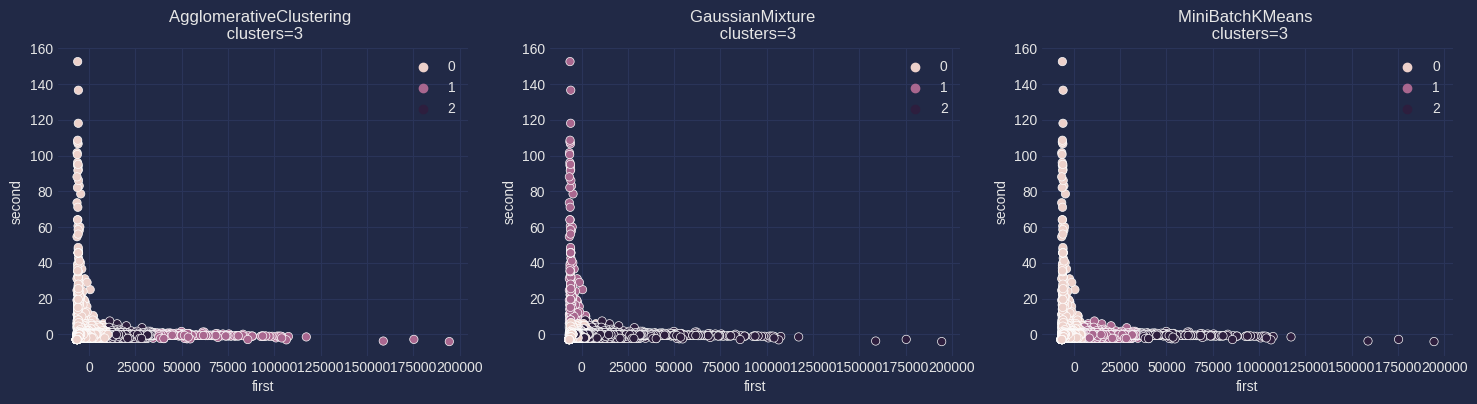

In [142]:
# визуализируем полученные результаты
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.scatterplot(x=df_lo_pca['first'], y=df_lo_pca['second'], hue=labels_ag_mode, ax=axes[0])
axes[0].set_title('AgglomerativeClustering \n clusters=3')
sns.scatterplot(x=df_lo_pca['first'], y=df_lo_pca['second'], hue=labels_gm_mode, ax=axes[1])
axes[1].set_title('GaussianMixture \n clusters=3')
sns.scatterplot(x=df_lo_pca['first'], y=df_lo_pca['second'], hue=labels_km_mode, ax=axes[2])
axes[2].set_title('MiniBatchKMeans \n clusters=3');

**На мой взгляд GaussianMixture на 3 кластера справилась лучше всех**

In [143]:
# Присваем каждому клиенту свой кластер и возвращаем обратно признак pop_ration
df_loyal['labels'] = labels_gm_mode
df_loyal['pop_ration'] = df['pop_ration']

In [144]:
# Разобьем кластера на отдельные датафреймы
df_one = df_loyal[df_loyal['labels'] == 0]
df_second = df_loyal[df_loyal['labels'] == 1]
df_third = df_loyal[df_loyal['labels'] == 2]

**Посмотрим на различия найденных нами кластеров**

___

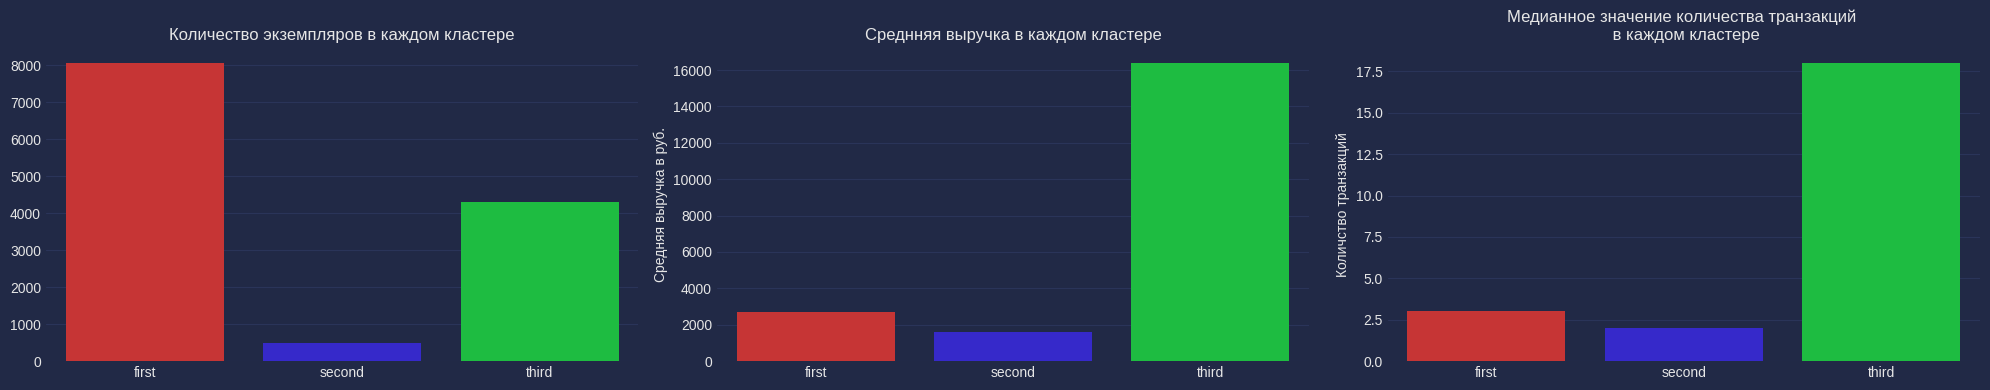

In [145]:
# Укажем цветом каждый кластер first-красный, second-синий, third-зеленый
palette = ['#de1d1d', '#200ee5', '#04d632']

fig, axes = plt.subplots(1, 3, figsize=(20, 4))

val_bar = sns.barplot(
    x=['first', 'second', 'third'],
    y=[len(df_one), len(df_second), len(df_third)],
    palette=palette, ax=axes[0]
    )
val_bar.set(title='Количество экземпляров в каждом кластере')
#--------------------------------------
rev_bar = sns.barplot(
    x=['first', 'second', 'third'],
    y=[
        df_one['revenue'].mean(),
        df_second['revenue'].mean(),
        df_third['revenue'].mean()
    ],
    palette=palette, ax=axes[1]
    )
rev_bar.set(
    title='Среднняя выручка в каждом кластере',
    ylabel='Средняя выручка в руб.'
    )
#--------------------------------------
sum_bar = sns.barplot(
    x=['first', 'second', 'third'],
    y=[
        df_one['sum_trans'].median(),
        df_second['sum_trans'].median(),
        df_third['sum_trans'].median()
        ],
    palette=palette, ax=axes[2]
    )
sum_bar.set(
    title='Медианное значение количества транзакций \n в каждом кластере',
    ylabel='Количство транзакций'
    )

plt.tight_layout();

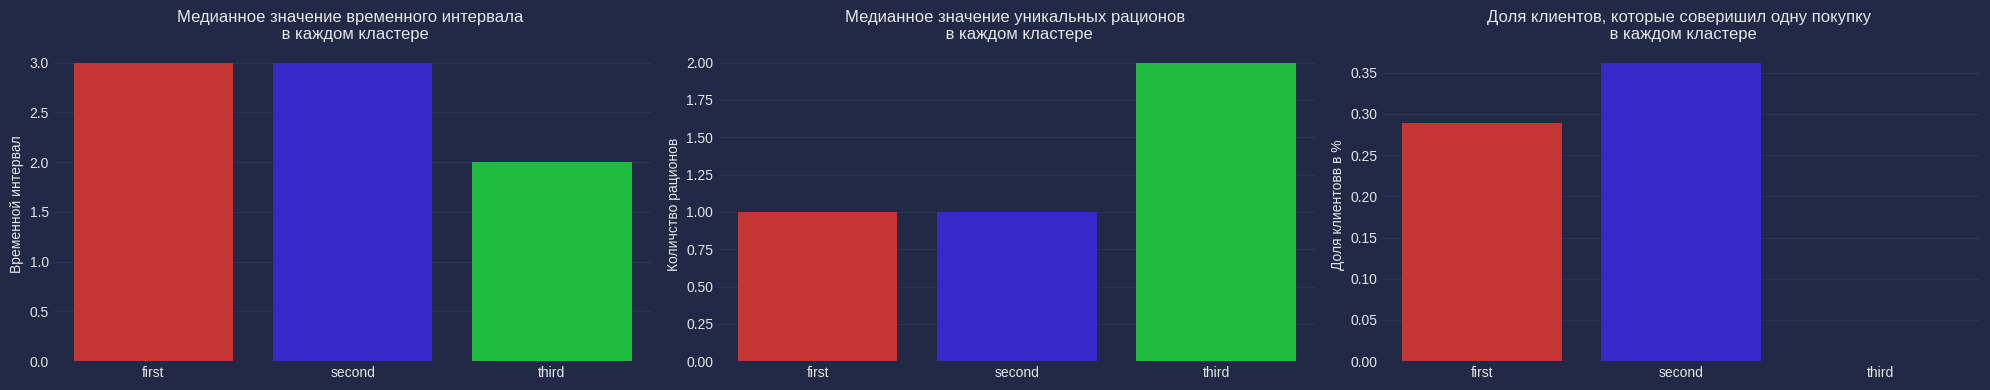

In [146]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))

time_bar = sns.barplot(
    x=['first', 'second', 'third'],
    y=[
        df_one['time_zone'].median(),
        df_second['time_zone'].median(),
        df_third['time_zone'].median()
        ],
    palette=palette, ax=axes[0]
    )
time_bar.set(
    title='Медианное значение временного интервала \n в каждом кластере',
    ylabel='Временной интервал'
    )
#--------------------------------------------------
uniq_bar = sns.barplot(
    x=['first', 'second', 'third'],
    y=[
        df_one['nuniq_ration'].median(),
        df_second['nuniq_ration'].median(),
        df_third['nuniq_ration'].median()
        ],
    palette=palette, ax=axes[1]
    )
uniq_bar.set(
    title='Медианное значение уникальных рационов \n в каждом кластере',
    ylabel='Количство рационов'
    )
#--------------------------------------------------
period_bar = sns.barplot(
    x=['first', 'second', 'third'],
    y=[
        df_one[df_one['period']==0]['period'].count() / df_one.shape[0],
        df_second[df_second['period']==0]['period'].count() / df_second.shape[0],
        df_third[df_third['period']==0]['period'].count() / df_third.shape[0]
        ],
    palette=palette, ax=axes[2]
    )
period_bar.set(
    title='Доля клиентов, которые соверишил одну покупку \n в каждом кластере',
    ylabel='Доля клиентовв в %'
    )

plt.tight_layout()

In [147]:
print(
    f"Популярный продукт в первой группе: {df_one['pop_ration'].agg(pd.Series.mode)[0]},\n\
Популярный продукт во второй группе: {df_second['pop_ration'].agg(pd.Series.mode)[0]},\n\
Популярный продукт в третьей группе: {df_third['pop_ration'].agg(pd.Series.mode)[0]}"
    )

Популярный продукт в первой группе: 1500,
Популярный продукт во второй группе: 1200,
Популярный продукт в третьей группе: 1500


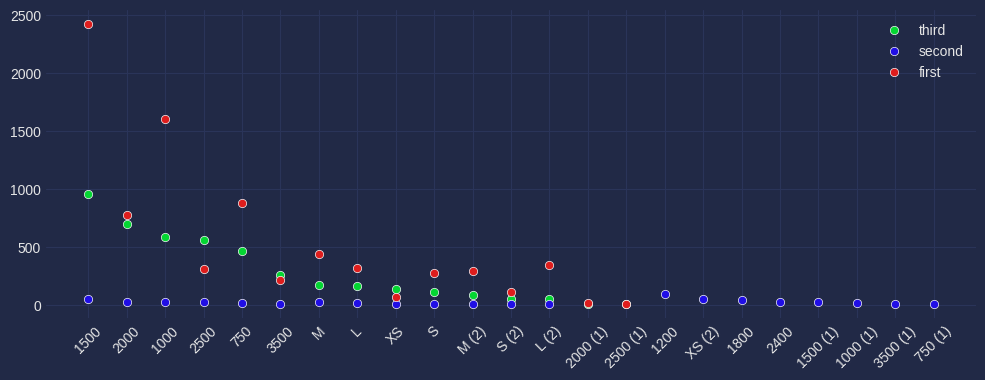

In [148]:
fig = plt.figure(figsize=(12, 4))

sns.scatterplot(
    x=df_third['pop_ration'].value_counts().index,
    y=df_third['pop_ration'].value_counts().values,
    color=palette[2], label='third'
    )
hist = sns.scatterplot(
    x=df_second['pop_ration'].value_counts().index,
    y=df_second['pop_ration'].value_counts().values,
    color=palette[1], label='second'
    )
sns.scatterplot(
    x=df_one['pop_ration'].value_counts().index,
    y=df_one['pop_ration'].value_counts().values,
    color=palette[0], label='first'
    )
hist.xaxis.set_tick_params(rotation=45)

plt.legend();

**Прежде чем сделать выводы по кластеризации, посмотрим как распространились наши группы по районам Екатеринбурга**

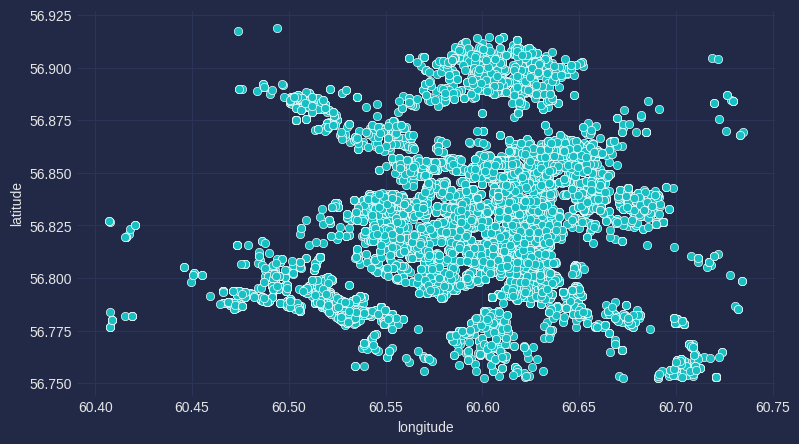

In [149]:
df_loc = df.loc[id_clients][['longitude', 'latitude']]

fig = plt.figure(figsize=(9, 5))
sns.scatterplot(x=df_loc['longitude'], y=df_loc['latitude']);

**Также разобьем весь город на кластеры, в нашем случае это будет обозначать районы города**

In [150]:
silhouette_list_loc = []
inertia_list_loc = []

for num in range(2, 20):
    silhouette_list_loc.append(get_silhouette(num, df_loc))

for i in range(1, 20):
    inertia_list_loc.append(get_inertia(i, df_loc))

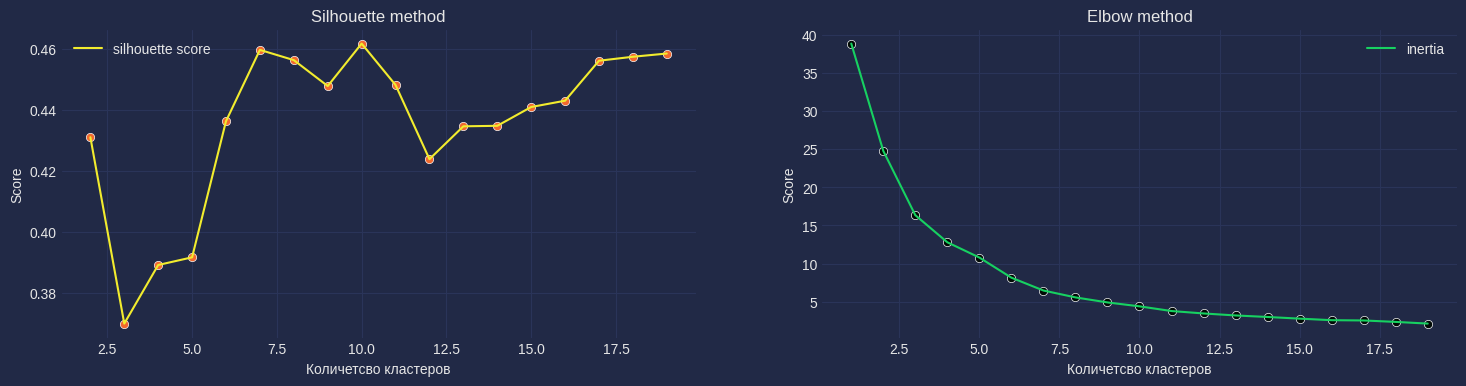

In [151]:
fig, axes = plt.subplots(1, 2, figsize=(18, 4))

line_sil = sns.lineplot(x=range(2, 20), y=silhouette_list_loc, label='silhouette score', color='#f2ec2e', ax=axes[0])
sns.scatterplot(x=range(2, 20), y=silhouette_list_loc, color='#f2692e', markers=True, ax=axes[0])
line_sil.set(title='Silhouette method', xlabel='Количетсво кластеров', ylabel='Score')

line_elbow = sns.lineplot(x=range(1, 20), y=inertia_list_loc, label='inertia', color='#17d161', ax=axes[1])
sns.scatterplot(x=range(1, 20), y=inertia_list_loc, color='#010a05', markers=True, ax=axes[1])
line_elbow.set(title='Elbow method', xlabel='Количетсво кластеров', ylabel='Score')

plt.legend();

**Судя по результатам методов, оптимальным числом кластеров будет 6**

In [152]:
ag = AgglomerativeClustering(n_clusters=6, linkage='ward')
labels_ag = ag_mode.fit_predict(df_loc)

gm_mode = GaussianMixture(n_components=6)
labels_gm = gm_mode.fit_predict(df_loc)

km_mode = MiniBatchKMeans(n_clusters=6, n_init='auto', random_state=14)
labels_km = km_mode.fit_predict(df_loc)

In [153]:
df_loc['ag'] = labels_ag
df_loc['gm'] = labels_gm
df_loc['km'] = labels_km

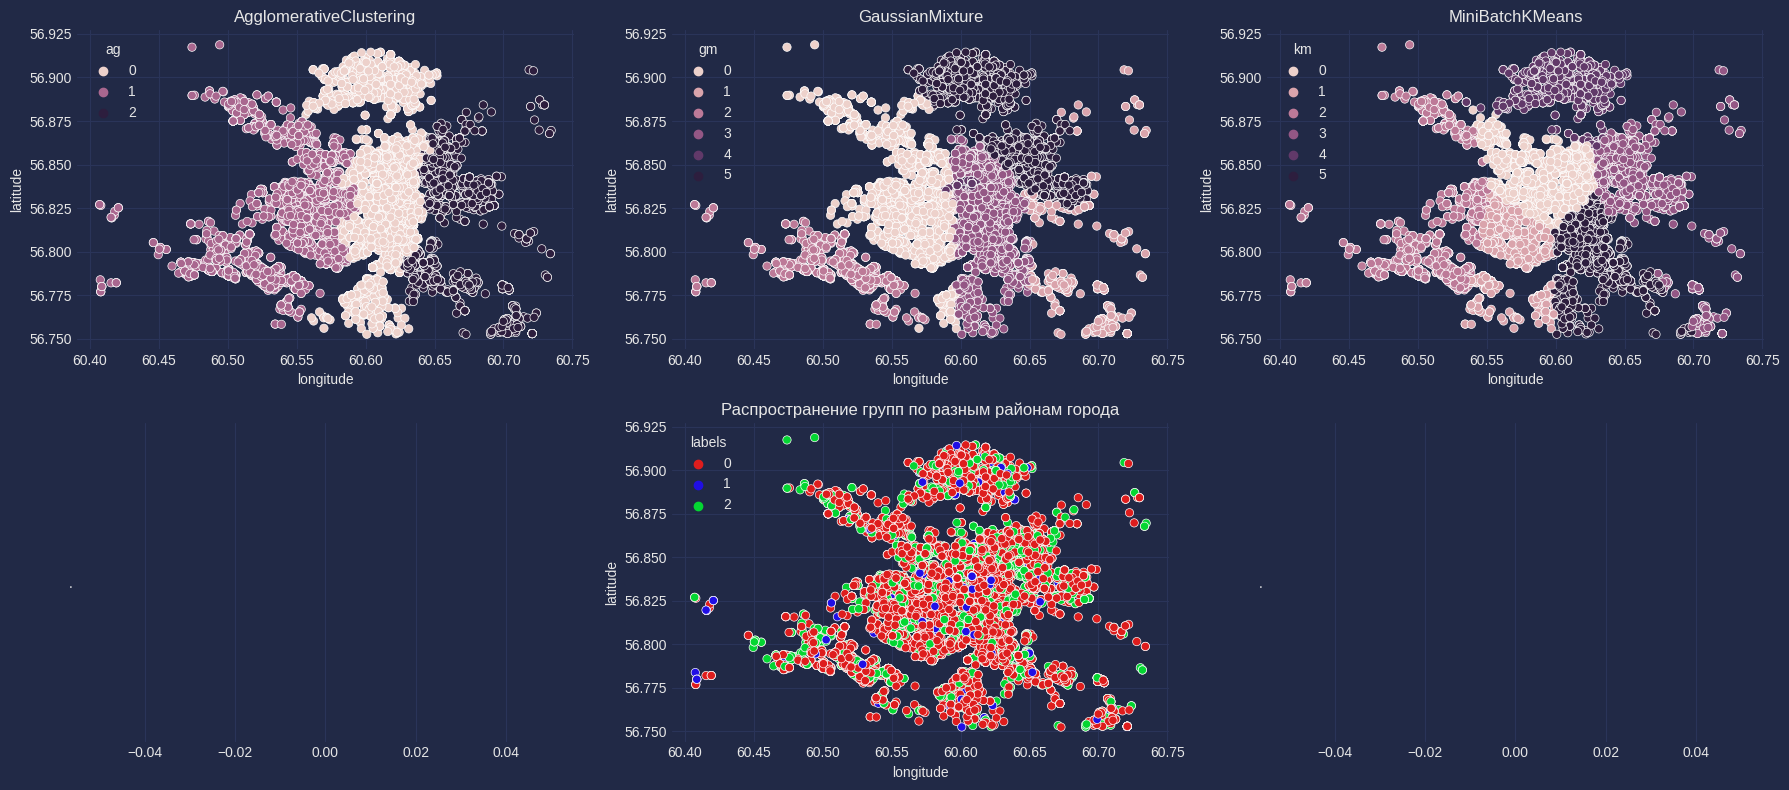

In [158]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

sns.scatterplot(
    x=df_loc['longitude'], y=df_loc['latitude'],
    hue=df_loc['ag'], ax=axes[0][0])

axes[0][0].set_title('AgglomerativeClustering')

sns.scatterplot(
    x=df_loc['longitude'], y=df_loc['latitude'],
    hue=df_loc['gm'], ax=axes[0][1]
    )
axes[0][1].set_title('GaussianMixture')

sns.scatterplot(
    x=df_loc['longitude'], y=df_loc['latitude'],
    hue=df_loc['km'], ax=axes[0][2]
    )
axes[0][2].set_title('MiniBatchKMeans')
#-------------------------------------------------
sns.barplot(x=[0], y=['.'], ax=axes[1][0])
sns.scatterplot(x=df_loc['longitude'], y=df_loc['latitude'], hue=df_loyal['labels'], palette=palette, ax=axes[1][1])
axes[1][1].set_title('Распространение групп по разным районам города')
sns.barplot(x=[0], y=['.'], ax=axes[1][2])
plt.tight_layout();

**Кластеризация метода kmeans справилась лучше с разбеением города на районы**

**Выводы**

* 1. Если посмотреть на график кластеризации по районам, то видно, что наши группы находятся в каждом кластере. Это означает, что особое внимание на район делать не нужно
* 2. БОльшее число клиентов попало в третью группу.
* 3. Первая группа отличается от остальных двух тем, что в бОльшей степени заказывала рационы на один день. Вторая и третья группа больше всего берут рационы на два дня.
* 4. Во второй группе нет ни одного клиента, который заказал бы всего один раз.
* 5. Вторая группа больше всего эксперементирует с рационами. Хотя переход от одного рациона к другому чаще всего совершается всего лишь один раз. Первая и третья группа более постоянны.
* 6. Вторая группа предпочитает более ранние интервал доставки(7-9) нежели первая и вторая группа(8-10).
* 7. Вторая группа больше всего принесла прибыли компании и у этой же группы больше всего совершенно покупок.